In [ ]:
import matplotlib.pyplot as plt
import numpy as np

## Extract Entities
Some Examples 
https://catalog.ldc.upenn.edu/docs/LDC2013T19/OntoNotes-Release-5.0.pdf

2.6 Entity Names Annotation
Names (often referred to as “Named Entities”) are annotated according to the following
set of types:
PERSON People, including fictional
NORP Nationalities or religious or political groups
FACILITY Buildings, airports, highways, bridges, etc.
ORGANIZATION Companies, agencies, institutions, etc.
GPE Countries, cities, states
LOCATION Non-GPE locations, mountain ranges, bodies of water
PRODUCT Vehicles, weapons, foods, etc. (Not services)
EVENT Named hurricanes, battles, wars, sports events, etc.
WORK OF ART Titles of books, songs, etc.
LAW Named documents made into laws 
 OntoNotes Release 5.0
22
LANGUAGE Any named language
The following values are also annotated in a style similar to names:
DATE Absolute or relative dates or periods
TIME Times smaller than a day
PERCENT Percentage (including “%”)
MONEY Monetary values, including unit
QUANTITY Measurements, as of weight or distance
ORDINAL “first”, “second”
CARDINAL Numerals that do not fall under another typ

In [9]:
import os
# Install java
!java -version
#! sudo apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
#os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
#os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
!free -g

openjdk version "1.8.0_252"
OpenJDK Runtime Environment (build 1.8.0_252-8u252-b09-1~deb9u1-b09)
OpenJDK 64-Bit Server VM (build 25.252-b09, mixed mode)
              total        used        free      shared  buff/cache   available
Mem:             31           1          29           0           0          29
Swap:             0           0           0


In [10]:
import sparknlp
import json
import os
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from sparknlp.annotator import *
from sparknlp.base import *
from pyspark.sql.functions import from_unixtime
from pyspark.sql.functions import unix_timestamp
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.stat import Correlation
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import col, to_timestamp,date_format
from pyspark import StorageLevel
import pyspark.sql.functions as F
from sparknlp.pretrained import PretrainedPipeline
from collections import Counter
from wordcloud import WordCloud
from sparknlp.base import Finisher, DocumentAssembler
from sparknlp.annotator import (Tokenizer, Normalizer,LemmatizerModel, StopWordsCleaner)
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

def start():
    builder = SparkSession.builder \
        .appName("Entity Analyzer") \
        .master("local[*]") \
        .config("spark.driver.memory", "24G") \
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
        .config("spark.kryoserializer.buffer.max", "2040M") \
        .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.11:2.5.1") \
        .config("fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem") \
        .config("fs.AbstractFileSystem.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFS")
    return builder.getOrCreate()
spark = start()
spark.version
!ps -ef | grep spark

jupyter   2659  2549 64 04:01 ?        00:00:15 /usr/lib/jvm/java-8-openjdk-amd64/bin/java -cp /opt/conda/lib/python3.7/site-packages/pyspark/conf:/opt/conda/lib/python3.7/site-packages/pyspark/jars/* -Xmx24G org.apache.spark.deploy.SparkSubmit --conf spark.master=local[*] --conf spark.driver.memory=24G --conf spark.kryoserializer.buffer.max=2040M --conf spark.jars.packages=com.johnsnowlabs.nlp:spark-nlp_2.11:2.5.1 --conf spark.serializer=org.apache.spark.serializer.KryoSerializer --conf spark.app.name=Entity Analyzer --conf fs.AbstractFileSystem.gs.impl=com.google.cloud.hadoop.fs.gcs.GoogleHadoopFS --conf fs.gs.impl=com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem pyspark-shell
jupyter   2813  2549  0 04:02 pts/4    00:00:00 /bin/sh -c ps -ef | grep spark
jupyter   2815  2813  0 04:02 pts/4    00:00:00 grep spark


In [11]:
#spark.version
!ps -ef | grep spark
!free -g
#!kill -9 23363

jupyter   2659  2549 61 04:01 ?        00:00:15 /usr/lib/jvm/java-8-openjdk-amd64/bin/java -cp /opt/conda/lib/python3.7/site-packages/pyspark/conf:/opt/conda/lib/python3.7/site-packages/pyspark/jars/* -Xmx24G org.apache.spark.deploy.SparkSubmit --conf spark.master=local[*] --conf spark.driver.memory=24G --conf spark.kryoserializer.buffer.max=2040M --conf spark.jars.packages=com.johnsnowlabs.nlp:spark-nlp_2.11:2.5.1 --conf spark.serializer=org.apache.spark.serializer.KryoSerializer --conf spark.app.name=Entity Analyzer --conf fs.AbstractFileSystem.gs.impl=com.google.cloud.hadoop.fs.gcs.GoogleHadoopFS --conf fs.gs.impl=com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem pyspark-shell
jupyter   2816  2549  0 04:02 pts/4    00:00:00 /bin/sh -c ps -ef | grep spark
jupyter   2818  2816  0 04:02 pts/4    00:00:00 grep spark
              total        used        free      shared  buff/cache   available
Mem:             31           1          29           0           0          29
Swap:    

In [ ]:
%%time
#!pip install pybind11
#!pip install nmslib
!pip install scispacy spacy
#!pip install googletrans
#!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_ner_bc5cdr_md-0.2.4.tar.gz
#!pip install pytextrank
#!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_sm-0.2.4.tar.gz
#!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_md-0.2.4.tar.gz
#!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_web_sm-0.2.4.tar.gz
!python3 -m spacy download en_core_web_sm    

In [77]:
def find_custom_entity_sentiments(text_col, pos=['PROPN']):
    
    nlp = spacy.load('en_core_web_sm')
    custom_people = {}
    custom_organisations = {}
    
    persons = [('boris johnson','johnson'),('boris','johnson'),('johnson','johnson'),('prime minister','johnson'),
               ('primeminister','johnson'),('matt','hancock'),('hancock','hancock'),('matt hancock','hancock'),
               ('health secretary','hancock'),('deborah birx ','birx'),('deborah','birx'),('birx','birx'),
              ('anthony stephen fauci','fauci'),('anthony fauci','fauci'),('POTUS','trump'),('trump','trump'),
               ('president of united states','trump'),('donald trump','trump')]
    orgs = [('nhs','nhs'),('cdc','cdc'),('who','who'),('world health organization','who'),('fda','fda'),
            ('government','government')]
    
    ruler_persons = EntityRuler(nlp, overwrite_ents=True)
    ruler_orgs = EntityRuler(nlp, overwrite_ents=True)

    for (p,i) in persons:
        ruler_persons.add_patterns([{"label": "PERSON", "pattern": [{"LOWER": p}], "id": i}])
    for (o,i) in orgs:
        ruler_orgs.add_patterns([{"label": "ORG", "pattern": [{"LOWER": o}], 'id': i}])

    ruler = EntityRuler(nlp)
    ruler.add_patterns(ruler_orgs.patterns)
    ruler.add_patterns(ruler_persons.patterns)

    nlp.add_pipe(ruler)
    
    named_persons = ''
    named_orgs = ''
    for parsed in tqdm(nlp.pipe(text_col, disable=['ner'])):
        
        doc_ = ''
        for token in parsed:
            if token.pos_ in pos:
                doc_ += str(token) + ' '
            else:
                pass
        doc_ = doc_.strip()
                
        polarity = analyser.polarity_scores(doc_)['compound']
        if parsed.ents:
            for ent in parsed.ents:
                named_persons = ''
                named_orgs = ''
                if ent.label_ == 'PERSON':
                    named_persons += ent.ent_id_ + ''
                if ent.label_ == 'ORG':
                    named_orgs += ent.ent_id_ + ''
                else:
                    pass
        else:
            named_persons = ''
            named_orgs = ''

        named_persons = named_persons.strip()
        named_orgs = named_orgs.strip()
        
        if (named_persons != ''):
            custom_people[named_persons] = custom_people.get(named_persons, 0) + polarity
            #custom_people[named_persons] /= len(custom_people)
        if (named_orgs != ''):    
            custom_organisations[named_orgs] = custom_organisations.get(named_orgs, 0) + polarity
            #custom_organisations[named_orgs] /= len(custom_organisations)  
        
    return custom_people,custom_organisations

In [12]:
#!pip install spacy
import pyspark.sql.types as t
import pyspark.sql.functions as f
import spacy
from spacy.lang.en import English
from spacy.pipeline import EntityRuler
import re
import scispacy
from scispacy.abbreviation import AbbreviationDetector
from scispacy.umls_linking import UmlsEntityLinker
import en_core_web_sm
from tqdm.notebook import tqdm
import sys
import time
import glob

def find_custom_entities(text_col, pos=['PROPN']):
    
    nlp = spacy.load('en_core_web_sm')
    custom_people = {}
    custom_organisations = {}
    
    persons = [('boris johnson','johnson'),('boris','johnson'),('johnson','johnson'),('prime minister','johnson'),
               ('primeminister','johnson'),('matt','hancock'),('hancock','hancock'),('matt hancock','hancock'),
               ('health secretary','hancock'),('deborah birx ','birx'),('deborah','birx'),('birx','birx'),
              ('anthony stephen fauci','fauci'),('anthony fauci','fauci'),('POTUS','trump'),('president of united states','trump'),('Donald Trump','trump')]
    orgs = [('nhs','nhs'),('cdc','cdc'),('who','who'),('world health organization','who'),('fda','fda'),('government','government')]
    
    ruler_persons = EntityRuler(nlp, overwrite_ents=True)
    ruler_orgs = EntityRuler(nlp, overwrite_ents=True)

    for (p,i) in persons:
        ruler_persons.add_patterns([{"label": "PERSON", "pattern": [{"LOWER": p}], "id": i}])
    for (o,i) in orgs:
        ruler_orgs.add_patterns([{"label": "ORG", "pattern": [{"LOWER": o}], 'id': i}])

    ruler = EntityRuler(nlp)
    ruler.add_patterns(ruler_orgs.patterns)
    ruler.add_patterns(ruler_persons.patterns)

    nlp.add_pipe(ruler)
    
    named_persons = ''
    named_orgs = ''
    for parsed in tqdm(nlp.pipe(text_col, disable=['ner'])):
        if parsed.ents:
            for ent in parsed.ents:
                named_persons = ''
                named_orgs = ''
                if ent.label_ == 'PERSON':
                    named_persons += ent.ent_id_ + ''
                if ent.label_ == 'ORG':
                    named_orgs += ent.ent_id_ + ''
                else:
                    pass
        else:
            named_persons = ''
            named_orgs = ''

        named_persons = named_persons.strip()
        named_orgs = named_orgs.strip()
        
        if (named_persons != ''):
            custom_people[named_persons] = custom_people.get(named_persons, 0) + 1
        if (named_orgs != ''):    
            custom_organisations[named_orgs] = custom_organisations.get(named_orgs, 0) + 1
            
    return custom_people,custom_organisations

In [13]:
!pip install vaderSentiment
import sparknlp
import json
import os
from sparknlp.annotator import *
from sparknlp.base import *
from pyspark.sql.functions import from_unixtime
from pyspark.sql.functions import unix_timestamp
from pyspark.sql.functions import *
from pyspark.sql.functions import explode, col
from pyspark.sql.functions import from_unixtime, to_date, asc, year, udf, explode, split, col, desc, length, rank, dense_rank, avg, sum

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

def calc_polarity(text):    
    return analyser.polarity_scores(text)['compound']
    
#calc_polarity = udf(calc_polarity)
#spark.udf.register("calc_polarity", calc_polarity)

import json
import seaborn as sns
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
eng_stopwords = stopwords.words('english')

def remove_stopwords(x):    
    sw = stopwords.words("english")
    string = ''
    for x in x.split(' '):
        if x.lower() not in sw:
            string += x + ' '
        else:
            pass
    return string

#nosw = udf(remove_stopwords)
#spark.udf.register("nosw", nosw)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
from sparknlp.base import Finisher, DocumentAssembler
from sparknlp.annotator import (Tokenizer, Normalizer,LemmatizerModel, StopWordsCleaner)
from pyspark.ml import Pipeline
documentAssembler = DocumentAssembler() \
    .setInputCol('text') \
    .setOutputCol('document')

tokenizer = Tokenizer() \
    .setInputCols(['document']) \
    .setOutputCol('token')

# note normalizer defaults to changing all words to lowercase.
# Use .setLowercase(False) to maintain input case.
normalizer = Normalizer() \
    .setInputCols(['token']) \
    .setOutputCol('normalized') \
    .setLowercase(True)

# note that lemmatizer needs a dictionary. So I used the pre-trained
# model (note that it defaults to english)
lemmatizer = LemmatizerModel.pretrained() \
    .setInputCols(['normalized']) \
    .setOutputCol('lemma') \

stopwords_cleaner = StopWordsCleaner() \
    .setInputCols(['lemma']) \
    .setOutputCol('clean_lemma') \
    .setCaseSensitive(False) \
    .setStopWords(eng_stopwords) 

#eng_stopwords

# finisher converts tokens to human-readable output
finisher = Finisher() \
    .setInputCols(['clean_lemma']) \
    .setCleanAnnotations(False)

pipeline = Pipeline() \
    .setStages([
        documentAssembler,
        tokenizer,
        normalizer,
        lemmatizer,
        stopwords_cleaner,
        finisher
    ])

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [15]:
#!gsutil ls 'gs://covid19-tweets/2020-04/'
parquetFile1 = spark.read.parquet("parquetFile1.parquet")

In [ ]:
spark.conf.set("spark.sql.files.ignoreCorruptFiles", "true")
spark.conf.set("spark.sql.legacy.allowCreatingManagedTableUsingNonemptyLocation","true")
spark.conf.set("spark.sql.execution.arrow.fallback.enabled","true")
import numpy as np
import pandas as pd

#df1 = spark.read.format("json").load("gs://covid19-tweets/2020-03/*.gz")
#df2 = spark.read.format("json").load( "gs://covid19-tweets/2020-04/*.gz")

dfTest = parquetFile1.where(col("full_text").isNotNull()).withColumnRenamed('full_text','text').select("text")
dfTest.createOrReplaceTempView("entityView1")
dfTest = spark.sql(""" select * from entityView1""")
cleanDF = pipeline.fit(dfTest).transform(dfTest) 

cleanDF.show(10)

In [19]:
cleanDF.select("finished_clean_lemma").repartition(20).write.save("parquetFile4.parquet")
print('Done Saving Data')
parquetFile2 = spark.read.parquet("parquetFile4.parquet")
parquetFile2.createOrReplaceTempView("entityView2")
fastDF = spark.sql("""select finished_clean_lemma as text from entityView2""")
fastDF.show(2)

Done Saving Data
+--------------------+
|                text|
+--------------------+
|[rt, chhr, q, pos...|
|[rt, dalebolsonar...|
+--------------------+
only showing top 2 rows



In [ ]:
fastDF = spark.sql("""select explode(finished_clean_lemma) as text from entityView2""")
fastDF.show(20)

In [23]:
pdf = fastDF.toPandas()
people,organisations = find_custom_entities(pdf['text'])

In [ ]:
#dfTest.count()
import pandas as pd
df1 = pd.DataFrame(list(people.items()),columns = ['person','count'])
df1 = df1.sort_values('count',ascending = False)
print (df1)
df1.plot(kind='bar')

df2 = pd.DataFrame(list(organisations.items()),columns = ['org','count'])
df2 = df2.sort_values('count',ascending = False)
print (df2)
df2.plot(kind='bar')

In [38]:
#dfTest.count()
pdf2 = dfTest.toPandas()

In [83]:
persons_sentiment_v2,orgs_sentiment_v2 = find_custom_entity_sentiments(pdf2.sample(800000)['text'])

    person     count
0    trump -126.7111
3     birx  -12.9179
2  hancock   -7.3268
1  johnson   -2.3247


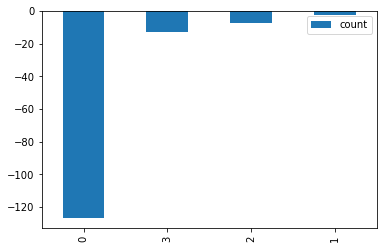

In [103]:
dfa = pd.DataFrame(list(persons_sentiment_v2.items()),columns = ['person','count'])
dfa = dfa.sort_values('count',ascending = True)
print (dfa)
dfa.plot(kind='bar')

          org     count
2         who  618.7265
0  government  118.5657
1         nhs   72.9029
3         cdc   -1.8540
4         fda   -3.0997


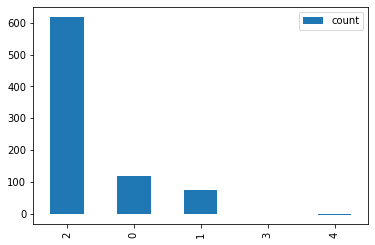

In [104]:
dfb = pd.DataFrame(list(orgs_sentiment_v2.items()),columns = ['org','count'])
dfb = dfb.sort_values('count',ascending = False)
print (dfb)
dfb.plot(kind='bar')

In [96]:
persons_sentiment,orgs_sentiment = find_custom_entity_sentiments(pdf.sample(500000)['text'])

    person  count
0  johnson   1194
2  hancock   1135
1     birx   1045


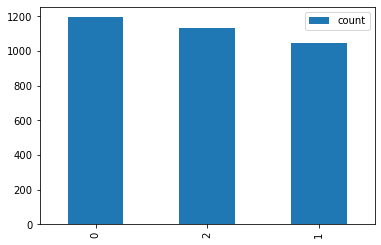

In [98]:
df3 = pd.DataFrame(list(persons_sentiment.items()),columns = ['person','count'])
df3 = df1.sort_values('count',ascending = False)
print (df3)
df3.plot(kind='bar')


In [66]:
peopleFreqn,organisationFreqn,nationalgroupFreqn,eventFreqn, facilityFreqn , productFreqn,locationFreqn = find_entity_count(pdf['text'])


In [ ]:
df4 = pd.DataFrame(list(organisationFreqn.items()),columns = ['org','count'])
df4 = df4.sort_values('count',ascending = False).head(10)
print (df4)

In [69]:
peoplePolarity,organisationsPolarity,nationalgroupsPolarity,eventsPolarity, facilitiesPolarity , productsPolarity,locationsPolarity = find_entity_polarity(pdf['text'])

In [ ]:
df2 = DataFrame(list(peopleFreqn.items()),columns = ['person','count'])
df3 = df2.sort_values('count',ascending = False).head(10)
print (df3)

personPlot1 = df3.plot(kind='bar')

In [ ]:
df2 = DataFrame(list(organisationsFreqn.items()),columns = ['org','count'])
df3 = df2.sort_values('count',ascending = False).head(20)
print (df3)

organisationsPlot1 = df3.plot(kind='bar')

In [ ]:
df2 = DataFrame(list(nationalgroupsFreqn.items()),columns = ['group','count'])
df3 = df2.sort_values('count',ascending = False).head(10)
print (df3)
nationalgroupsPlot1 = df3.plot(kind='bar')

In [ ]:
peoplePolarity,organisationsPolarity,nationalgroupsPolarity,eventsPolarity, facilitiesPolarity , productsPolarity,locationsPolarity = find_entity_polarity(pdf['text'])

In [ ]:
#topPeopleWithPositiveEffect = sorted(peoplePolarity.items(),key=operator.itemgetter(1),reverse=True)
from pandas import DataFrame
df = DataFrame(list(peoplePolarity.items()),columns = ['person','polarity'])
df1 = df.sort_values('polarity',ascending = False).head(20)
print (df1)

personPlot = df1.plot(kind='bar')

In [ ]:
df = DataFrame(list(peoplePolarity.items()),columns = ['person','polarity'])
df1 = df.sort_values('polarity',ascending = True).head(20)
print (df1)

personPlot = df1.plot(kind='bar')

In [ ]:
df = DataFrame(list(locationsPolarity.items()),columns = ['location','polarity'])
df1 = df.sort_values('polarity',ascending = True).head(20)
print (df1)

locationPlot = df1.plot(kind='bar')

In [ ]:
from pandas import DataFrame
df = DataFrame(list(organisationsPolarity.items()),columns = ['org','polarity'])
df1 = df.sort_values('polarity',ascending = False).head(20)
print (df1)

personPlot = df1.plot(kind='bar')

In [ ]:
from pandas import DataFrame
df = DataFrame(list(organisationsPolarity.items()),columns = ['org','polarity'])
df1 = df.sort_values('polarity',ascending = True).head(20)
print (df1)

personPlot = df1.plot(kind='bar')

In [ ]:
#!pip install jupyterlab
#!pip install ipympl
#!curl -sL https://deb.nodesource.com/setup_12.x | bash -
#!apt install nodejs
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager
#!jupyter labextension install jupyter-matplotlib


#!jupyter labextension update --all 
#!jupyter lab build 
#!jupyter nbextension list
#!jupyter labextension list


In [ ]:
#%matplotib inline
#%pylab inline

import matplotlib.pyplot as plt
import numpy as np
import pylab as p

keys = peopleFreqn.keys()
vals = peopleFreqn.values()

plt.bar(keys, vals, label="Real distribution")

plt.ylim(0,1)
plt.ylabel ('Count')
plt.xlabel ('Persons')
plt.xticks(list(keys))
plt.legend (bbox_to_anchor=(1, 1), loc="upper right", borderaxespad=0.)

plt.show()
#plt.ion()

In [ ]:
!free -g
!ps -ef | grep spark
#spark.sql("""DROP VIEW IF EXISTS entityView1""")

In [ ]:
# Testing matplotlib interactions with a simple plot
fig = plt.figure()
plt.plot(np.sin(np.linspace(0, 20, 100)));

In [ ]:
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.canvas.resizable = False
fig.canvas

In [64]:
def find_entity_count(text_col, pos=['PROPN']):
    nlp = spacy.load('en_core_web_sm')
    #nlp = en_core_web_sm.load()
    #tokens = []
    
    people = {}
    organisations = {}
    nationalgroups={}
    events={}
    facilities={}
    products={}
    locations={}
    
    named_persons = ''
    named_orgs = ''
    named_groups = ''
    named_events = ''
    named_facilities = ''
    named_products = ''
    named_locations = ''

    for parsed in tqdm(nlp.pipe(text_col)):
        doc_ = ''
        for token in parsed:
            if token.pos_ in pos:
                doc_ += str(token) + ' '
            else:
                pass
        doc_ = doc_.strip()

        #tokens.append(doc_)

        if parsed.ents:
            for ent in parsed.ents:
                named_persons = ''
                named_orgs = ''
                named_groups = ''
                named_events = ''
                named_facilities = ''
                named_products = ''
                named_locations = ''
                
                if ent.label_ == 'PERSON':
                    named_persons += ent.text + ''
                if ent.label_ == 'ORG':
                    named_orgs += ent.text + ''
                if ent.label_ == 'NORP':
                    named_groups += ent.text + ''
                if ent.label_ == 'EVENT':
                    named_events += ent.text + ''
                if ent.label_ == 'FACILITY':
                    named_facilities += ent.text + ''
                if ent.label_ == 'PRODUCT':
                    named_products += ent.text + ''  
                if ent.label_ == 'GPE':
                    named_locations += ent.text + ''    
                else:
                    pass
        else:
            named_persons = ''
            named_orgs = ''
            named_groups = ''
            named_events = ''
            named_facilities = ''
            named_products = ''
            named_locations = ''
        
        named_persons = named_persons.strip()
        named_orgs = named_orgs.strip()
        named_events = named_events.strip()
        named_groups = named_groups.strip()
        named_facilities = named_facilities.strip()
        named_products = named_products.strip()
        named_locations = named_locations.strip()
        
        if (named_persons != ''):
            people[named_persons] = people.get(named_persons, 0) + 1
        if (named_orgs != ''):    
            organisations[named_orgs] = organisations.get(named_orgs, 0) + 1
        if (named_groups != ''):    
            nationalgroups[named_groups] = nationalgroups.get(named_groups, 0) + 1
        if (named_events != ''):
            events[named_events] = events.get(named_events, 0) + 1
        if (named_facilities != ''):
            facilities[named_facilities] = facilities.get(named_facilities, 0) + 1
        if (named_products != ''):
            products[named_products] = products.get(named_products, 0) + 1
        if (named_locations != ''):
            locations[named_locations] = locations.get(named_locations, 0) + 1   
    
    return people,organisations,nationalgroups,events, facilities , products,locations

In [68]:
# Sentiment Analysis for Topic
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer() 
    
def find_entity_polarity(text_col, pos=['PROPN']):
    nlp = spacy.load('en_core_web_sm')
    #nlp = en_core_web_sm.load()
    #tokens = []
    
    people = {}
    organisations = {}
    nationalgroups={}
    events={}
    facilities={}
    products={}
    locations={}
    
    named_persons = ''
    named_orgs = ''
    named_groups = ''
    named_events = ''
    named_facilities = ''
    named_products = ''
    named_locations = ''
    
    for parsed in tqdm(nlp.pipe(text_col)):
        
        doc_ = ''
        for token in parsed:
            if token.pos_ in pos:
                doc_ += str(token) + ' '
            else:
                pass
        doc_ = doc_.strip()
        
        vader_score = analyzer.polarity_scores(doc_)['compound']

        #tokens.append(doc_)

        if parsed.ents:
            for ent in parsed.ents:
                named_persons = ''
                named_orgs = ''
                named_groups = ''
                named_events = ''
                named_facilities = ''
                named_products = ''
                named_locations = ''
                
                if ent.label_ == 'PERSON':
                    named_persons += ent.text + ''
                if ent.label_ == 'ORG':
                    named_orgs += ent.text + ''
                if ent.label_ == 'NORP':
                    named_groups += ent.text + ''
                if ent.label_ == 'EVENT':
                    named_events += ent.text + ''
                if ent.label_ == 'FACILITY':
                    named_facilities += ent.text + ''
                if ent.label_ == 'PRODUCT':
                    named_products += ent.text + ''  
                if ent.label_ == 'GPE':
                    named_locations += ent.text + ''    
                else:
                    pass
        else:
            named_persons = ''
            named_orgs = ''
            named_groups = ''
            named_events = ''
            named_facilities = ''
            named_products = ''
            named_locations = ''
        
        named_persons = named_persons.strip()
        named_orgs = named_orgs.strip()
        named_events = named_events.strip()
        named_groups = named_groups.strip()
        named_facilities = named_facilities.strip()
        named_products = named_products.strip()
        named_locations = named_locations.strip()
        
        
        
        if (named_persons != ''):
            people[named_persons] = (people.get(named_persons, 0) + vader_score)
        if (named_orgs != ''):    
            organisations[named_orgs] = (organisations.get(named_orgs, 0) + vader_score)
        if (named_groups != ''):    
            nationalgroups[named_groups] = (nationalgroups.get(named_groups, 0) + vader_score)
        if (named_events != ''):
            events[named_events] = (events.get(named_events, 0) + vader_score)
        if (named_facilities != ''):
            facilities[named_facilities] = (facilities.get(named_facilities, 0) + vader_score)
        if (named_products != ''):
            products[named_products] = (products.get(named_products, 0) + vader_score)
        if (named_locations != ''):
            locations[named_locations] = (locations.get(named_locations, 0) + vader_score)
    
    return people,organisations,nationalgroups,events, facilities , products,locations    